Denoising fMRI data and functional connectivity estimation using aCompCor
===============================================

This is test script for denoising and FC estimation from fMRI data (1 subject) preprocessed in fmriprep.

**Method**: aCompCor with regressing out six motion parameters

Step 1: Importing packages
-------------------------------------------

In [78]:
%reset
%matplotlib inline

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn import preprocessing # for normalization of confounds columns

from nilearn import datasets # for fetching atlas
from nilearn import plotting 
from nilearn import input_data
from nilearn import signal
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Step 2: Creating atlas
-------------------------------------------

In [79]:
# Loading Power ROIs coordinates

power = datasets.fetch_coords_power_2011()
power_coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

# Creating masker file

power_spheres = input_data.NiftiSpheresMasker(
    seeds = power_coords, 
    smoothing_fwhm = 6, 
    radius = 5,
    detrend = True, 
    standardize = True,
    low_pass = 0.08, 
    high_pass = 0.009,
    t_r = 2
)

Step 3: Loading data
-----------------------

In [80]:
# Loading functional data
top_dir = '/home/finc/Downloads/fmriprep/'

sub = 'sub-01'
ses = 'ses-1'
task = 'dualnback'

sub_dir = top_dir + sub + '/' + ses + '/func/'

suffix = 'space-MNI152NLin2009cAsym_preproc.nii.gz'
#suffix = 'space-MNI152NLin2009cAsym_variant-smoothAROMAnonaggr_preproc.nii.gz'

dual_data = sub_dir + sub + '_' + ses + '_task-' + task + '_bold_' + suffix


Step 4: Confound preprocessing
-----------------------------------

In [86]:
# Loading confound data

confounds_path = sub_dir + sub + '_' + ses + '_task-' + task + '_bold_confounds.tsv'
confounds = pd.read_csv(confounds_path, delimiter = '\t')

confounds_clean = confounds[confounds.filter(regex='CSF|WhiteMatter|aCompCor|X|Y|Z|RotX|RotY|RotZ').columns]
#confounds_clean['LinearTrend'] = list(range(1,341))

# Standardize confounds
x = confounds_clean.values
standardize = preprocessing.StandardScaler()
x_scaled = standardize.fit_transform(x)
confounds_clean = pd.DataFrame(x_scaled, columns = confounds_clean.columns)

# Save preprocessed confound file
confounds_clean.to_csv(sub_dir + 'confounds_' + task + '_clean_acompcor.csv', sep = ',', index = False)
confounds_clean_path = sub_dir + 'confounds_' + task + '_clean_acompcor.csv'

confounds_clean.head()

,CSF,WhiteMatter,aCompCor00,aCompCor01,aCompCor02,aCompCor03,aCompCor04,aCompCor05,X,Y,Z,RotX,RotY,RotZ
0,1.514890,1.670018,-0.212445,-0.279174,1.434394,-0.577496,0.320911,-0.950788,2.519729,0.168914,-1.246139,0.886310,-2.297682,0.746276
1,1.335976,0.339101,-1.277477,-0.415930,-0.239572,0.603783,0.261672,-0.055013,2.527428,0.123940,-0.702176,0.726255,-2.258782,0.657778
2,1.215602,0.767958,-1.102417,-0.350196,-0.213752,0.125815,-1.444943,1.110857,2.462317,0.330250,-0.666198,0.957930,-2.382701,0.729110
3,2.375021,1.773731,-0.388581,-0.277538,0.177998,-0.664507,-0.618556,1.598467,2.576484,1.185252,-0.870800,1.027005,-2.258782,0.681465
4,2.220708,2.167298,0.397204,-0.156939,0.297621,-0.341546,1.079186,0.123002,2.576601,1.092152,-1.178947,0.820573,-2.427739,0.598921


Step 5: Extracting timeseries
-----------------------------------------------

In [82]:
timeseries_power = power_spheres.fit_transform(dual_data, confounds = confounds_clean_path)

Step 6: Calculating correlations
--------------------------------------------------------------

In [83]:
# Calculating static FC matrix

correlation_measure = ConnectivityMeasure(kind = 'correlation')
fc_power = correlation_measure.fit_transform([timeseries_power])[0]


Step 7: Plotting
--------------------------------------------------------------

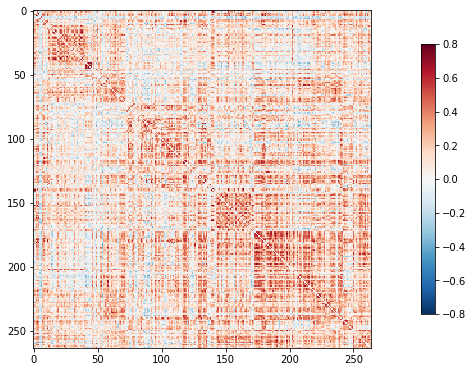

In [87]:
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(fc_power, 0)

# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation

#fc_power = np.arctanh(fc_power)
fc_power
plotting.plot_matrix(fc_power, vmin = -0.8, vmax = .8)
#plotting.plot_matrix(fc_power)

In [88]:
fc_power

array([[ 0.        ,  0.61312934, -0.04903266, ..., -0.03352696,
         0.1513304 , -0.26436287],
       [ 0.61312934,  0.        ,  0.026284  , ...,  0.12516855,
         0.26507806, -0.12928292],
       [-0.04903266,  0.026284  ,  0.        , ...,  0.40704389,
         0.09873433,  0.0888202 ],
       ..., 
       [-0.03352696,  0.12516855,  0.40704389, ...,  0.        ,
         0.18851854,  0.26883727],
       [ 0.1513304 ,  0.26507806,  0.09873433, ...,  0.18851854,
         0.        ,  0.26493272],
       [-0.26436287, -0.12928292,  0.0888202 , ...,  0.26883727,
         0.26493272,  0.        ]])

(array([   260.,   1810.,   6890.,  14710.,  18362.,  15148.,   8440.,
          3246.,    734.,     96.]),
 array([-0.44483833, -0.32137319, -0.19790805, -0.07444291,  0.04902223,
         0.17248737,  0.29595251,  0.41941765,  0.54288278,  0.66634792,
         0.78981306]),
 <a list of 10 Patch objects>)

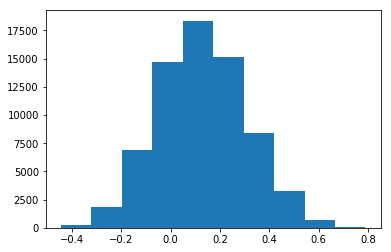

In [89]:
plt.hist(np.ravel(fc_power))